## Deep Learning
## Transfer Learning

<br>

#### Activity 2c: Exploring Transfer Learning with CIFAR-10
<br>

- Objective:

    In this activity, you'll study the concept of Transfer Learning, a powerful technique to improve the performance of your models by leveraging pre-trained architectures. The provided notebook offers a complete solution using a specific pre-trained model on the CIFAR-10 dataset. Your task is to extend this by trying out two other pre-trained models.
    
- Instructions:

    This activity should be submitted in the same format as previous activities. Remember to include the names of all team members in a markdown cell at the beginning of the notebook. The grade obtained in this notebook will be averaged with that of Activity 2b, for the grade of Activity 2.    

    Study the Provided Code: The provided notebook has a complete Transfer Learning solution using a particular pre-trained model. Make sure you understand the flow of the code and the role of each component.

    Select Two Other Pre-trained Models: Choose two different pre-trained models available in PyTorch's model zoo.

    Apply Transfer Learning: Add cells to implement Transfer Learning using the two models you've chosen. Train these models on the CIFAR-10 dataset.

    Evaluation: After training, evaluate your models' performance. Compare the results with the provided solution and try to interpret why there might be differences.

    Documentation: In a markdown cell, summarize your findings. Include any challenges you faced, how you overcame them, and any interesting insights you gained from comparing the different pre-trained models.

- Note:

    Although the provided code serves as a guide, you're encouraged to implement the new solutions on your own. The goal is to reinforce your understanding of Transfer Learning and how to apply it effectively.



In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
from torchvision import models

# Extra libraries used in the notebook
from tqdm import tqdm  # Import tqdm for the progress bar
from copy import deepcopy

In [ ]:
import matplotlib.pyplot as plt

### Dataset download

In [ ]:
# DATA_PATH = '/media/pepe/DataUbuntu/Databases/cifar-10/cifar-10-batches-py'
DATA_PATH = './cifar10'
NUM_TRAIN = 45000
MINIBATCH_SIZE = 64
transform_imagenet = T.Compose([
                T.Resize(224),
                T.ToTensor(),
                T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
            ])

transform_cifar = T.Compose([
                T.ToTensor(),
                T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.261])
            ])

# Training set loader
cifar10_train = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                             transform=transform_imagenet)
train_loader = DataLoader(cifar10_train, batch_size=MINIBATCH_SIZE,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

# Validation set loader
cifar10_val = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                           transform=transform_imagenet)
val_loader = DataLoader(cifar10_val, batch_size=MINIBATCH_SIZE,
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, len(cifar10_val))))

# Testing set loader
cifar10_test = datasets.CIFAR10(DATA_PATH, train=False, download=True,
                            transform=transform_imagenet)
test_loader = DataLoader(cifar10_test, batch_size=MINIBATCH_SIZE)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
for i, (x, y) in enumerate(val_loader):
    print(i, x.shape, y.shape)

### Change device to GPU

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


### Show some images

La imagen muestreada representa un: Ship


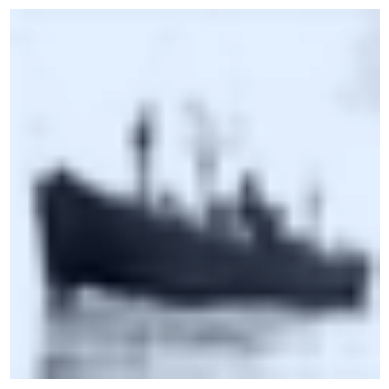

In [ ]:
classes = ['Plane', 'Car', 'Bird', 'Cat', 'Deer','Dog', 'Frog', 'Horse', 'Ship', 'Truck']

def plot_figure(image):
    plt.imshow(image.permute(1,2,0))
    plt.axis('off')
    plt.show()

rnd_sample_idx = np.random.randint(len(test_loader))
print(f'La imagen muestreada representa un: {classes[test_loader.dataset[rnd_sample_idx][1]]}')
image = test_loader.dataset[rnd_sample_idx][0]
image = (image - image.min()) / (image.max() -image.min() )
plot_figure(image)

### Accuracy calculation

In [ ]:
def accuracy(model, loader):
    num_correct = 0
    num_total = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for (xi, yi) in loader:
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            scores = model(xi) # mb_size, 10
            _, pred = scores.max(dim=1) #pred shape (mb_size )
            num_correct += (pred == yi).sum() # pred shape (mb_size), yi shape (mb_size, 1)
            num_total += pred.size(0)
        return float(num_correct)/num_total



### Load the pre-trained model

In [ ]:
model_resnet18 = models.resnet18(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### Exploring the pre-trained model

In [ ]:
for i, w in enumerate(model_resnet18.parameters()):
    print(i, w.shape, w.requires_grad)

0 torch.Size([64, 3, 7, 7]) True
1 torch.Size([64]) True
2 torch.Size([64]) True
3 torch.Size([64, 64, 3, 3]) True
4 torch.Size([64]) True
5 torch.Size([64]) True
6 torch.Size([64, 64, 3, 3]) True
7 torch.Size([64]) True
8 torch.Size([64]) True
9 torch.Size([64, 64, 3, 3]) True
10 torch.Size([64]) True
11 torch.Size([64]) True
12 torch.Size([64, 64, 3, 3]) True
13 torch.Size([64]) True
14 torch.Size([64]) True
15 torch.Size([128, 64, 3, 3]) True
16 torch.Size([128]) True
17 torch.Size([128]) True
18 torch.Size([128, 128, 3, 3]) True
19 torch.Size([128]) True
20 torch.Size([128]) True
21 torch.Size([128, 64, 1, 1]) True
22 torch.Size([128]) True
23 torch.Size([128]) True
24 torch.Size([128, 128, 3, 3]) True
25 torch.Size([128]) True
26 torch.Size([128]) True
27 torch.Size([128, 128, 3, 3]) True
28 torch.Size([128]) True
29 torch.Size([128]) True
30 torch.Size([256, 128, 3, 3]) True
31 torch.Size([256]) True
32 torch.Size([256]) True
33 torch.Size([256, 256, 3, 3]) True
34 torch.Size([25

In [ ]:
model_resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Model adjustment

In [ ]:
model_aux = nn.Sequential(*list(model_resnet18.children()))
model_aux

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
model_aux = nn.Sequential(*list(model_resnet18.children())[:-1])

In [ ]:
model_aux

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
for i, parameter in enumerate(model_aux.parameters()):
    parameter.requires_grad = False

In [ ]:
for parameter in model_aux.parameters():
    assert parameter.requires_grad == False

### Training Loop

In [ ]:
def train(model, optimiser, epochs=100):
    model = model.to(device=device)

    # Lists to store loss and accuracy for each epoch
    loss_values = []
    acc_values = []

    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0

        for i, (xi, yi) in enumerate(train_loader):
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)

            # Forward pass
            scores = model(xi)
            cost = F.cross_entropy(input=scores, target=yi)

            # Backpropagation and optimization
            optimiser.zero_grad()
            cost.backward()
            optimiser.step()

            running_loss += cost.item()

        # Compute validation accuracy after each epoch
        acc = accuracy(model, val_loader)

        # Calculate average loss for the epoch
        avg_loss = running_loss / len(train_loader)

        # Store the loss and accuracy
        loss_values.append(avg_loss)
        acc_values.append(acc)

        print(f'Epoch: {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {acc:.4f}')

    # Plotting the loss and accuracy after training
    epochs_range = range(1, epochs + 1)

    plt.figure(figsize=(14, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, loss_values, label='Training Loss', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, acc_values, label='Validation Accuracy', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()



According to the professor's recomendation on the video provided in the course, a learning rate finder function was implemented to find the best learning rate for the model.

### Reference

YouTube - [ResNet 56 en PyTorch – ¡Redes Neuronales Residuales desde cero usando 1 cycle policy!](https://www.youtube.com/watch?v=WTygqid7cFA)

In [ ]:

def lr_finder(model, train_loader, init_value=1e-7, final_value=10, beta=0.98):
    num = len(train_loader) - 1
    mult = (final_value / init_value) ** (1/num)
    lr = init_value
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    avg_loss = 0.0
    best_loss = 0.0
    losses = []
    log_lrs = []
    model = model.to(device=device)
    model.train()

    # Add the loading bar
    with tqdm(total=len(train_loader), desc="Finding Optimal Learning Rate") as pbar:
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            # Set learning rate
            lr *= mult
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr

            # Forward pass
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Track the best loss
            avg_loss = beta * avg_loss + (1 - beta) * loss.item()
            smoothed_loss = avg_loss / (1 - beta**(i + 1))

            # Stop if the loss is exploding
            if i > 1 and smoothed_loss > 4 * best_loss:
                break

            # Record the best loss
            if smoothed_loss < best_loss or i == 0:
                best_loss = smoothed_loss

            # Backpropagate
            loss.backward()
            optimizer.step()

            # Store the values
            losses.append(smoothed_loss)
            log_lrs.append(np.log10(lr))

            # Update the loading bar
            pbar.set_postfix({"loss": smoothed_loss, "lr": lr})
            pbar.update(1)

    return log_lrs, losses


# Original model using ResNet18, This is the code provided by the instructor



In [ ]:
hidden1 = 256
hidden = 256
lr = 5e-4
epochs = 3

model1 = nn.Sequential(model_aux,
                       nn.Flatten(),
                       nn.Linear(in_features=512, out_features= 10, bias=True))
optimiser = torch.optim.Adam(model1.parameters(), lr=lr, betas=(0.9, 0.999))


In [ ]:
model1

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

Epoch: 1/3, Loss: 0.9865, Accuracy: 0.7830
Epoch: 2/3, Loss: 0.6646, Accuracy: 0.7928
Epoch: 3/3, Loss: 0.6165, Accuracy: 0.7982


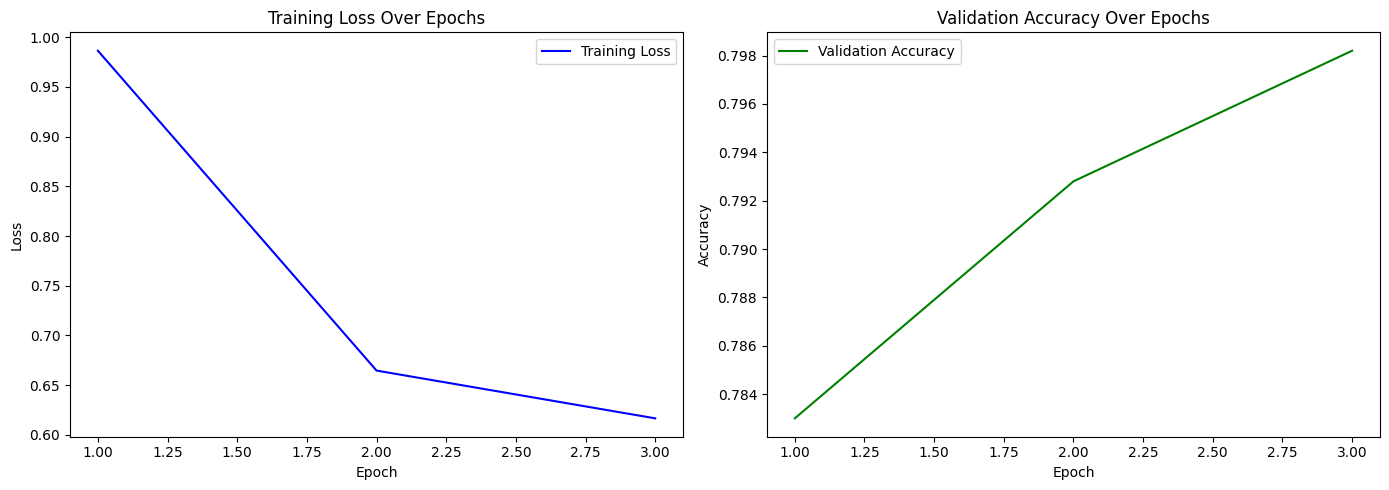

In [ ]:
train(model1, optimiser, epochs)

In [ ]:
accuracy(model1, test_loader)

0.7997

## Implementation using VGG16 pretrained model for transfer learning

This code is based on the model VGG16, the model is loaded and the last layer is modified to fit the CIFAR-10 dataset.

To consult the model architecture, you can visit the following link: https://pytorch.org/vision/stable/_modules/torchvision/models/vgg.html#vgg16

In [ ]:
# First we load the model VGG16 from the torchvision library

model_vgg16 = models.vgg16(pretrained=True)

# We can see the original model architecture
model_vgg16

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Change the requires_grad flag to False for all the parameters in the model, to avoid updating them

for i, parameter in enumerate(model_vgg16.parameters()):
    parameter.requires_grad = False

# Validate that the requires_grad flag is False for all the parameters in the model
for parameter in model_vgg16.parameters():
    assert parameter.requires_grad == False


In [ ]:
# Add the custom classifier to the model, by overwriting the last layer of the classifier
model_vgg16.classifier[6] = nn.Linear(in_features=4096, out_features=10, bias=True)



Finding Optimal Learning Rate:  74%|███████▍  | 520/704 [02:03<00:43,  4.22it/s, loss=3.29, lr=0.0827]  


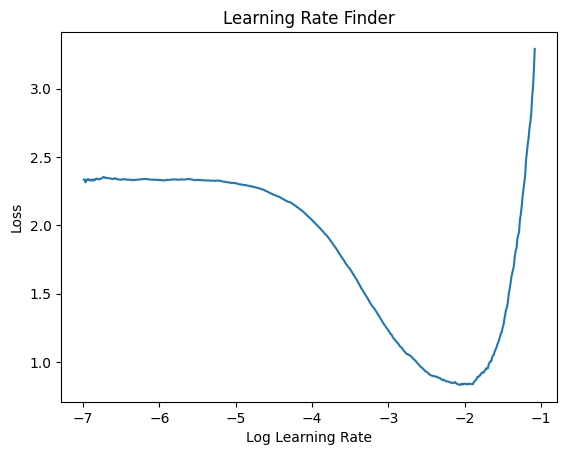

In [ ]:
# Setup a copy of the model to use the LR finder
model_vgg16_aux = deepcopy(model_vgg16)

# Now we can use this function
log_lrs, losses = lr_finder(model_vgg16_aux, train_loader)

# Plot the results to visualize the optimal learning rate
plt.plot(log_lrs, losses)
plt.xlabel("Log Learning Rate")
plt.ylabel("Loss")
plt.title("Learning Rate Finder")
plt.show()


The plot shows a typical curve from a learning rate finder, where:

- At very low learning rates (around 1e−7 to 1e−5), the loss remains relatively constant and high. This indicates that the learning rate is too small for the model to make significant updates.

- As the learning rate increases (from around 1e−5 to 1e−2), the loss starts to decrease sharply. This suggests that the model is learning effectively within this range.

- After a certain point (around 1e−1), the loss begins to increase rapidly. This signals that the learning rate is too high and is destabilizing the training process.

Based on the plot, the optimal learning rate is typically chosen just before the sharp rise in loss. In this case, a learning rate around 1e−3 appears to be the best choice.

```
lr = 1e-3
```

Epoch: 1/5, Loss: 0.6570, Accuracy: 0.8202
Epoch: 2/5, Loss: 0.5897, Accuracy: 0.8386
Epoch: 3/5, Loss: 0.5848, Accuracy: 0.8486
Epoch: 4/5, Loss: 0.5836, Accuracy: 0.8372
Epoch: 5/5, Loss: 0.5814, Accuracy: 0.8478


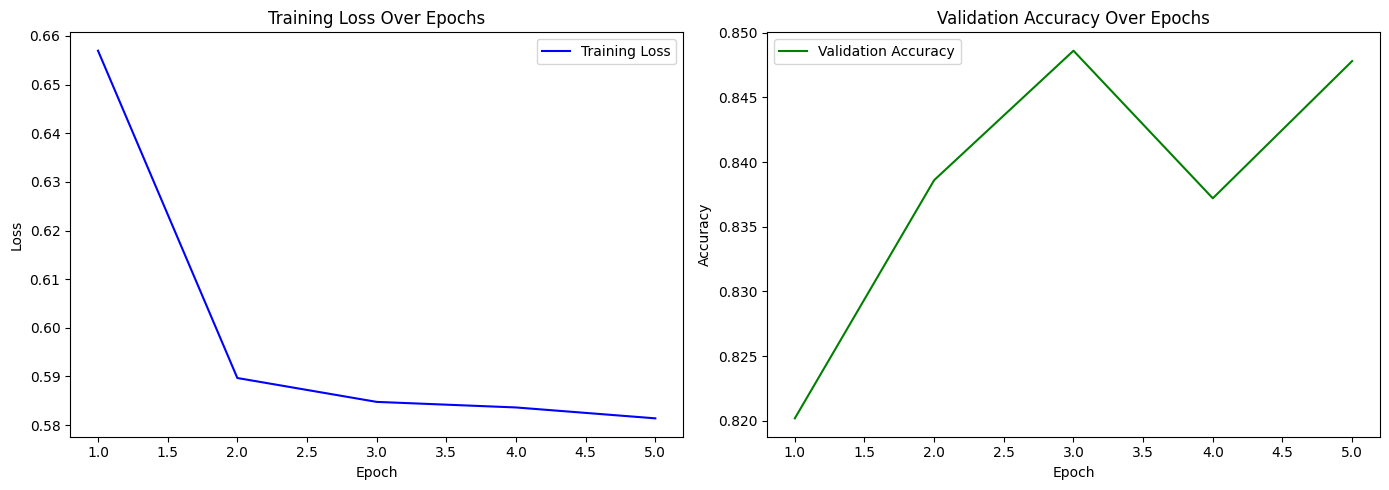

In [ ]:
# Setup random seed
torch.manual_seed(42)
np.random.seed(42)

# Setup learning rate and optimiser
learning_rate = 1e-3

# weight_decay is the L2 regularisation parameter. This will be a fixed value of 1e-4
# This information was provided in class by the professor.
weight_decay = 1e-4

optimiser_vgg16 = torch.optim.Adam(model_vgg16.parameters(), lr=learning_rate, weight_decay=weight_decay)
epochs = 5

# Start training process
train(model_vgg16, optimiser_vgg16, epochs)

## Implementation using AlexNet pretrained model for transfer learning

This code is based on the model AlexNet, the model is loaded and the last layer is modified to fit the CIFAR-10 dataset.

To consult the model architecture, you can visit the following link: https://pytorch.org/vision/stable/_modules/torchvision/models/alexnet.html#alexnet

In [ ]:
model_alexnet = models.alexnet(pretrained=True)

model_alexnet

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:00<00:00, 302MB/s] 


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
# Change the requires_grad flag to False for all the parameters in the model, to avoid updating them

for i, parameter in enumerate(model_alexnet.parameters()):
    parameter.requires_grad = False

# Validate that the requires_grad flag is False for all the parameters in the model
for parameter in model_alexnet.parameters():
    assert parameter.requires_grad == False

In [ ]:
# Add the custom classifier to the model, by overwriting the last layer of the classifier

model_alexnet.classifier[6] = nn.Linear(in_features=4096, out_features=10, bias=True)

Finding Optimal Learning Rate:  72%|███████▏  | 509/704 [01:38<00:37,  5.18it/s, loss=3.59, lr=0.062]   


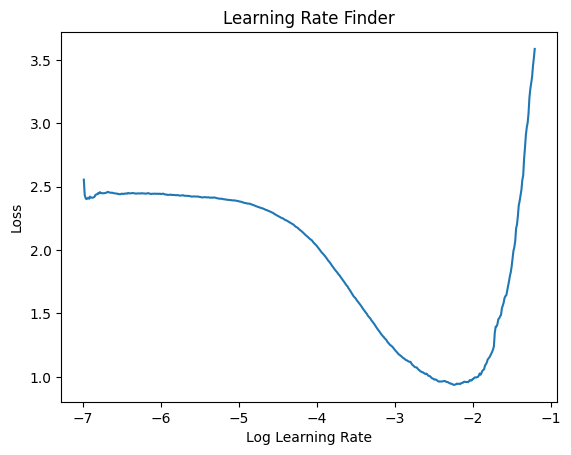

In [ ]:
# Setup a copy of the model to use the LR finder
model_alexnet_aux = deepcopy(model_alexnet)

# Now we can use this function
log_lrs, losses = lr_finder(model_alexnet_aux, train_loader)

# Plot the results to visualize the optimal learning rate
plt.plot(log_lrs, losses)
plt.xlabel("Log Learning Rate")
plt.ylabel("Loss")
plt.title("Learning Rate Finder")
plt.show()

The plot shows a typical curve from a learning rate finder, where:

- At very low learning rates (around 1e-7 to 1e-6), the loss starts slightly higher but remains relatively flat and constant, indicating that the learning rate is too small to make significant updates.

- As the learning rate increases (between 1e-6 and 1e-3), the loss starts to decrease steadily, suggesting that the model is learning more effectively within this range.

- There is a sharp rise in the loss around 1e-1, showing that the learning rate is too high and causing instability in the training process.

From this plot, the optimal learning rate is typically selected just before the steep increase in loss. Based on the curve, a learning rate of approximately 1e-3 appears to be a good choice for this model.

Epoch: 1/5, Loss: 0.7344, Accuracy: 0.8040
Epoch: 2/5, Loss: 0.6325, Accuracy: 0.8162
Epoch: 3/5, Loss: 0.6106, Accuracy: 0.8194
Epoch: 4/5, Loss: 0.5887, Accuracy: 0.8244
Epoch: 5/5, Loss: 0.5877, Accuracy: 0.8122


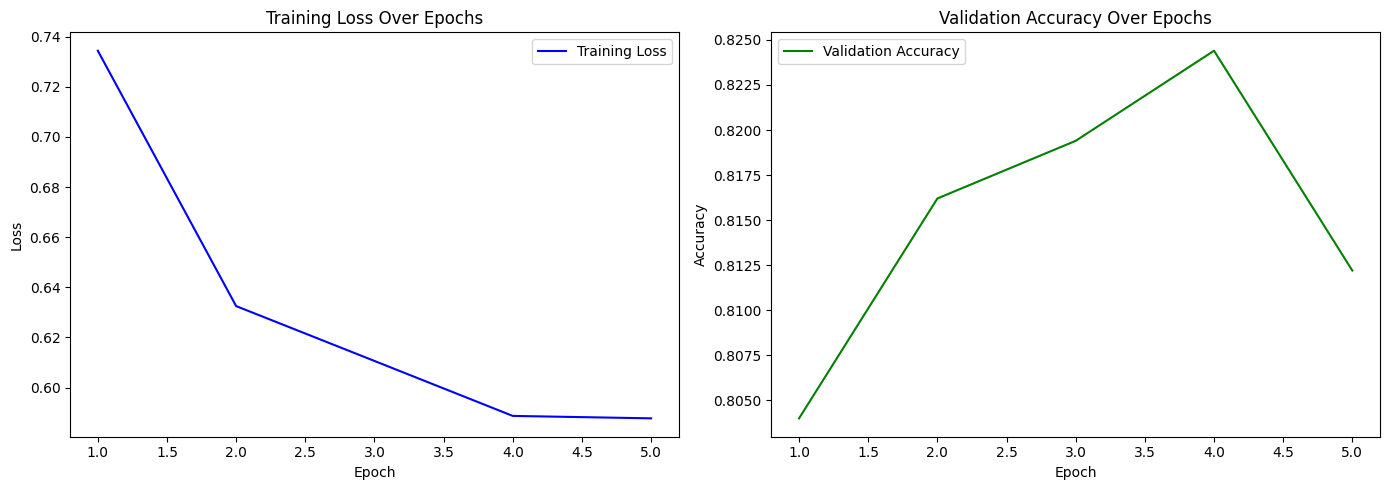

In [ ]:
# Setup random seed
torch.manual_seed(42)
np.random.seed(42)

# Setup learning rate and optimiser
learning_rate = 1e-3

# weight_decay is the L2 regularisation parameter. This will be a fixed value of 1e-4
# This information was provided in class by the professor.
weight_decay = 1e-4

optimiser_alexnet = torch.optim.Adam(model_alexnet.parameters(), lr=learning_rate, weight_decay=weight_decay)
epochs = 5

# Start training process
train(model_alexnet, optimiser_alexnet, epochs)

## Conclusion

In this exercise, we explored the use of Transfer Learning by applying two well-known pre-trained models, VGG16 and AlexNet, to the CIFAR-10 dataset. Transfer learning allows us to reuse models that were originally trained on large datasets, such as ImageNet, and fine-tune them for smaller, task-specific datasets like CIFAR-10. This approach significantly reduces the training time and allows us to benefit from the robust feature extraction capabilities of models trained on vast amounts of data.

We first used ResNet-18 as a baseline model, which was provided by the instructor. From there, we extended our work to VGG16 and AlexNet, comparing their performance on CIFAR-10. VGG16 achieved the highest accuracy due to its deeper architecture, which allowed it to extract more complex features from the dataset. AlexNet, though simpler and with fewer layers, also performed well but with slightly lower accuracy. ResNet-18, despite being a highly regarded model, performed marginally below the other two, possibly because of the relative simplicity of the CIFAR-10 dataset.

The exercise also introduced us to the learning rate finder technique, which allowed us to optimize the learning rate for each model. This was an important step in ensuring efficient training and faster convergence. Finding the right learning rate helped improve the performance of the models without requiring extensive hyperparameter tuning.

One of the main challenges we encountered was the high computational cost of training deep models like VGG16. To address this, we utilized cloud computing resources such as Google Colab, which provided the necessary processing power to train the models efficiently. Overall, this activity helped us gain a clearer understanding of transfer learning and its effectiveness, as well as practical strategies for improving model performance on smaller datasets.